# Assignment 3

The goal of this homework is to provide a realistic setting for a machine learning task.Therefore instructions will not specify the exact steps to carry out. Instead, it is part of the assignment to identify promising features, models and preprocessing methods and apply themas appropriate.

**The overall goal is to predict the price of a used vehicle on craigslist,** as can be found on kaggle: https://www.kaggle.com/austinreese/craigslist-carstrucks-data


You can find a description of the dataset and download it from there. *You do not have to usethe whole dataset, and it’s recommended that you strongly subsample the data whiledeveloping your solution.*

### Task 1 - Identify Features
- Assemble a dataset consisting of features and target (for example in a dataframe or in two arrays X and y).
- What features are relevant for the prediction task?
- Are there any features that should be excluded because they leak the target information?
- Show visualizations or statistics to support your selection.You are not required to use the description column, but you can try to come up with relevant features using it. Please don’t use bag-of-word approaches for now as we’ll discuss these later in the class.

Import libraries

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, MissingIndicator, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

- Load only a subset of the dataset (20% is loaded)
- Drop columns that contain URLs and the description since NLP techniques are not going to be used in this ML project. Also vin and id (identification features)
- Drop rows with price = 0

In [2]:
np.random.seed(26)
n = 435849
skiprows = random.sample(range(1,n),int(n*0.8))
data = pd.read_csv("data/vehicles.csv", skiprows = skiprows)
drop_cols = ['id','url','region_url','image_url','description','vin']
data.drop(drop_cols,axis=1, inplace=True)

In [3]:
data.reset_index(drop=True,inplace=True)
data = data[data['price']!=0]

In [4]:
print(data.drop('price',axis=1).columns.values)

['region' 'year' 'manufacturer' 'model' 'condition' 'cylinders' 'fuel'
 'odometer' 'title_status' 'transmission' 'drive' 'size' 'type'
 'paint_color' 'county' 'state' 'lat' 'long']


- **Localization features:** Region, county, state, lat and long.
- **Car features:** manufacturer, model, cylinders, fuel, transmission, vin, drive, size, type,paint_color
- **State features:** year, condition, odometer, title_status

### Target (PRICE)

There are a lot of impossible prices such as '3333333' or '1234567' that add noise to our analysis. I will delete values higher than a threshold (0 values and small valueslike 1,2,3,...)

In [8]:
price_threshold = data['price'].quantile(q=0.998)
price_threshold

88948.2700000009

In [10]:
low_threshold = data['price'].quantile(q=0.02)
low_threshold

500.0

In [11]:
color = ['red' if i > price_threshold else 'k' for i in data['price']]
size = [10 if i > price_threshold else 1 for i in data['price']]
analysis = data[(data['price']<price_threshold) & (data['price']>low_threshold)]

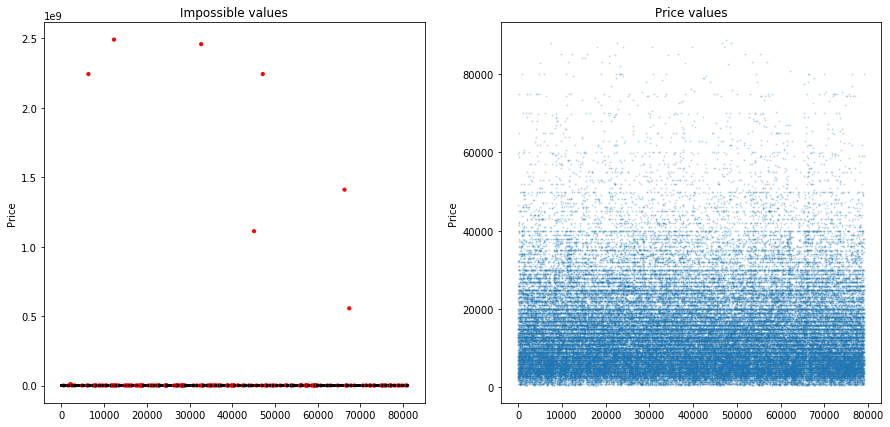

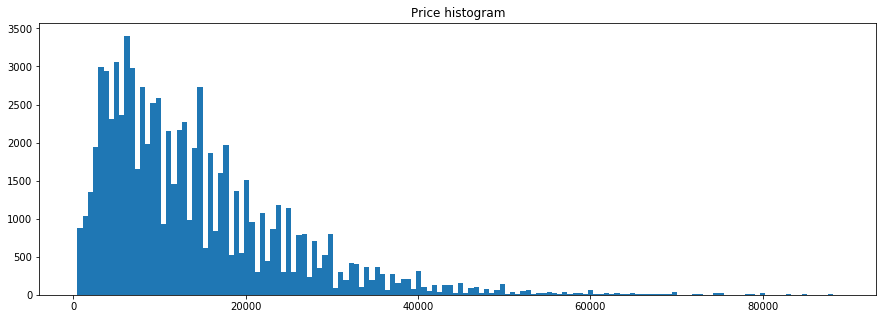

In [12]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,7))
ax[0].scatter(range(len(data['price'])),data['price'],s=size, c=color)
ax[1].scatter(range(len(analysis)),analysis['price'],s=1,alpha=0.2)

ax[1].set_title('Price values')
ax[0].set_title('Impossible values')
ax[0].set_ylabel('Price')
ax[1].set_ylabel('Price')

plt.show()

plt.figure(figsize=(15,5))
plt.hist(analysis['price'], bins='auto')
plt.title('Price histogram')
plt.show()

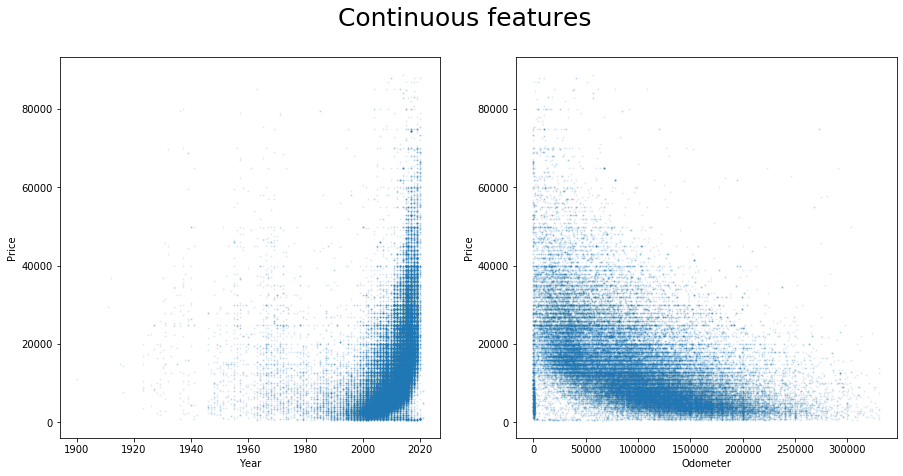

In [13]:
f, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(15,7))

plt.suptitle('Continuous features',fontsize=25)

ax[0].scatter(analysis.year,
              analysis.price,
              s=1,alpha=0.1)

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Price')


ax[1].scatter(analysis[analysis.odometer<analysis.odometer.quantile(.995)].odometer,
              analysis[analysis.odometer<analysis.odometer.quantile(.995)].price,
              s=1,alpha=0.1)

ax[1].set_xlabel('Odometer')
ax[1].set_ylabel('Price')

plt.show()

Once we eliminated noisy data, we can see clearly that this two features have a very strong correlation with the target.

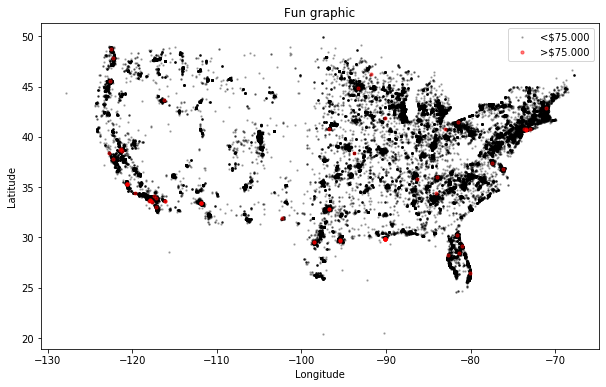

In [14]:
aa = analysis[(analysis['lat']>20)&(analysis['lat']<50)&(analysis['long']>-130)&(analysis['long']<-50)]
plt.figure(figsize=(10,6))
plt.scatter(aa.long,aa.lat,s=2,alpha=0.25,c='k',label='<$75.000')
plt.scatter(aa[aa['price']>75000].long,aa[aa['price']>75000].lat,s=10,alpha=0.5,c='r',label='>$75.000')
plt.title('Fun graphic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [15]:
cat = data.select_dtypes(include='object').columns
for c in cat:
    print(c,'-----> Unique values:',data[c].nunique())

region -----> Unique values: 402
manufacturer -----> Unique values: 42
model -----> Unique values: 13106
condition -----> Unique values: 6
cylinders -----> Unique values: 8
fuel -----> Unique values: 5
title_status -----> Unique values: 6
transmission -----> Unique values: 3
drive -----> Unique values: 3
size -----> Unique values: 4
type -----> Unique values: 13
paint_color -----> Unique values: 12
state -----> Unique values: 51


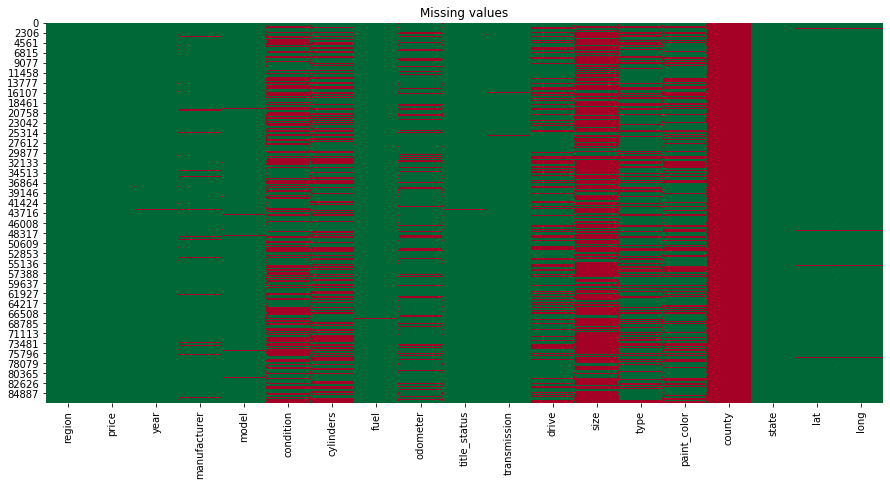

In [16]:
plt.figure(figsize=(15,7))
sns.heatmap(data.isnull(),cbar=False,cmap="RdYlGn_r")
plt.title('Missing values')
plt.show()

In [17]:
print('Missing %')
(data.isna().sum()/len(data)*100)

Missing %


region            0.000000
price             0.000000
year              0.260475
manufacturer      4.829272
model             1.462855
condition        40.908081
cylinders        37.456485
fuel              0.681431
odometer         16.683949
title_status      0.399970
transmission      0.460460
drive            27.672024
size             67.673999
type             27.138730
paint_color      30.443424
county          100.000000
state             0.000000
lat               0.893761
long              0.893761
dtype: float64

### Task 2 Preprocessing and Baseline Model
- Create a simple minimum viable model by doing:
    - an initial selection of features
    - appropriate preprocessing
    - cross-validating a linear model
    
    
- Feel free to exclude features or do simplified preprocessing for this task. 


*As mentioned before, you don’t need to validate the model on the whole dataset.*

#### Baseline model characteristics:
- **Excluded features:**
    - *size, county:* high missing values percentage
    - *lat, long:* redundant features
- **Label encoding** to categorical features with more than 15 categories
- **One hot encoding** to categorical features with less than 15 categorie
- **Mode/mean** imputation for missing values
- **Robust scaler** to continuous features
- **Ridge linear regression** model

In [18]:
np.random.seed(26)
categorical = ['region','manufacturer','condition','cylinders',
               'fuel','title_status','transmission','drive',
               'type','paint_color','state','model']

continuous = ['year','odometer']

baseline = analysis[categorical + continuous + ['price']].copy()

X_train, X_test, y_train, y_test = train_test_split(baseline.drop('price',axis=1),
                                                    baseline['price'],
                                                    test_size=0.2)

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [48]:
X_train_bl = pd.DataFrame(SimpleImputer(strategy='most_frequent').fit_transform(X_train),
                          columns=X_train.columns)

In [55]:
ordinal = []
one_hot = []

for cat in categorical:
    if X_train_bl[cat].nunique()>15:
        ordinal.append(cat)
    else:
        one_hot.append(cat)

preprocessor = ColumnTransformer([('label_encoding',ce.OrdinalEncoder(),ordinal),
                                  ('one_hot_encoding',ce.OneHotEncoder(),one_hot),
                                  ('scaler',RobustScaler(),continuous)])        

baseline_pipeline = Pipeline([('preprocessor',preprocessor),
                              ('regressor',Ridge())])

In [58]:
cv = cross_val_score(baseline_pipeline,
                     X_train_bl,y_train,
                     cv=5,
                     scoring='r2')

print('Cross validation results - R2:', round(cv.mean(),2),'%')

Cross validation results - R2: 0.35 %


In [94]:
baseline_pipeline.fit(X_train_bl,y_train)
print('Top features for Ridge - Baseline model:\n')
for j,i in enumerate(sorted(zip(abs(baseline_pipeline.named_steps['regressor'].coef_),X_train_bl.columns),reverse=True)[:20]):
    print(j+1,i[1])

Top features for Ridge - Baseline model:

1 model
2 odometer
3 drive
4 paint_color
5 state
6 type
7 transmission
8 fuel
9 title_status
10 year
11 region
12 manufacturer
13 cylinders
14 condition


### Task 3 Feature Engineering
- Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model?

- In particular, think about how to encode categorical variables and whether adding interactions (for example using PolynomialFeatures or manually) might help.

New preprocess:
- **Target encoding:** manufacturer, region, model and state
- **One hot encoding:** condition,cylinders,fuel,title_status,transmission,drive,size,type and paint_color
- Missing values flag
- Model driven missing imputation for continuous features

In [100]:
target_encoding = ['manufacturer','region','state','model']
onehot = ['condition','cylinders','fuel','title_status','transmission','drive','type','paint_color']

continuous = ['year','odometer']
categorical = ['region','manufacturer','condition','cylinders',
               'fuel','title_status','transmission','drive','type',
               'paint_color','state','model']

In [63]:
def add_missing_flag(X):
    
    '''
    Adds a missing flag column for each feature.
    '''
    
    missing_columns = []
    for i in X.columns.values:
        missing = i + '_Missing'
        missing_columns.append(missing)
        
    pre_length = len(X)
    
    df = pd.concat([X, 
               pd.DataFrame(MissingIndicator(features='all').fit_transform(X),
               columns=missing_columns)],
                  axis=1)
    
    df[pre_length:] = df[pre_length:].astype(int)
    
    return df

In [68]:
def odometer_imputer(X):
    
    '''
    Imputes odometer missing values with a Random Forest Regressor
    using Condition and year as features
    '''
    
    df = pd.DataFrame(columns=['condition','year','odometer'])
    df['condition'] = LabelEncoder().fit_transform(X['condition'].astype(str))
    df['year'] = X['year']
    df['odometer'] = X['odometer']
    imputer = IterativeImputer(estimator=RandomForestRegressor(),verbose=2)
    df = imputer.fit_transform(df)
    X[['condition','year','odometer']] = df
    
    return X

In [70]:
X_train_pp = odometer_imputer(add_missing_flag(X_train))

[IterativeImputer] Completing matrix with shape (63248, 3)
[IterativeImputer] Ending imputation round 1/10, elapsed time 32.78
[IterativeImputer] Change: 2879616.1223837934, scaled tolerance: 10000.0 
[IterativeImputer] Ending imputation round 2/10, elapsed time 65.09
[IterativeImputer] Change: 1462.5497619047528, scaled tolerance: 10000.0 
[IterativeImputer] Early stopping criterion reached.


In [101]:
preprocessor = ColumnTransformer([('target_encoding',ce.TargetEncoder(),target_encoding),
                                  ('one_hot_encoding',ce.OneHotEncoder(),onehot),
                                  ('poly',PolynomialFeatures(),continuous),
                                  ('scaler',RobustScaler(),continuous)])        

preprocessed_pipe = Pipeline([('preprocessor',preprocessor),
                              ('regressor',Ridge())])

In [102]:
cv = cross_val_score(preprocessed_pipe,
                     X_train_pp,y_train,
                     cv=5,
                     scoring='r2')

print('Cross validation results - R2:', round(cv.mean(),2),'%')

Cross validation results - R2: 0.61 %


In [103]:
preprocessed_pipe.fit(X_train_pp,y_train)
print('Top features for Ridge - Baseline model:\n')
for j,i in enumerate(sorted(zip(abs(preprocessed_pipe.named_steps['regressor'].coef_),X_train_pp.columns),reverse=True)[:20]):
    print(j+1,i[1])

Top features for Ridge - Baseline model:

1 year
2 model_Missing
3 odometer
4 type_Missing
5 manufacturer_Missing
6 paint_color
7 transmission
8 transmission_Missing
9 model
10 region_Missing
11 odometer_Missing
12 state_Missing
13 title_status
14 drive
15 year_Missing
16 state
17 paint_color_Missing
18 title_status_Missing
19 fuel_Missing
20 condition_Missing


R2 has increased from 35% to 61%

### Task 4 Any model
- Use any regression model we discussed (trees, forests, gradient boosting, SVM) to improve your result.
- You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models.
- Tune parametersas appropriate.

I will use XGBoost, it can handle missing values and there is no need to scale the data.
But encoding is still necessary. 

#### XGBoost without tuning

In [113]:
preprocessor = ColumnTransformer([('target_encoding',ce.TargetEncoder(),target_encoding),
                                  ('one_hot_encoding',ce.OneHotEncoder(),onehot),
                                  ('poly',PolynomialFeatures(),continuous)])        

xgb_no_tuning = Pipeline([('preprocessor',preprocessor),
                          ('regressor',XGBRegressor())])

In [114]:
cv = cross_val_score(xgb_no_tuning,
                     X_train_pp,y_train,
                     cv=5,
                     scoring='r2')

print('Cross validation results - R2:', round(cv.mean(),2),'%')

Cross validation results - R2: 0.79 %


#### XGBoost hyperparameter tuning

In [119]:
model = XGBRegressor(n_jobs=-1)

params = {'regressor__colsample_bytree':[0.5,0.7,0.9],
          'regressor__max_depth':[4,5,6,7,8],
          'regressor__subsample':[0.5,0.7,0.9],
          'regressor__gamma':[0,0.25,0.5,0.75,1],
          'regressor__reg_lambda': [0.1, 1, 5, 10, 50, 100],
          'regressor__n_estimators':[50,100,150,200,300]
         }

grid_search = RandomizedSearchCV(xgb_no_tuning,
                                 params,
                                 scoring = 'r2',
                                 cv = 5,verbose = 2,n_jobs = -1,
                                 n_iter = 30)

In [ ]:
grid_search.fit(X_train_pp,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.7min


In [ ]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')

In [ ]:
xgb_tuned = Pipeline([('preprocessor',preprocessor),
                      ('regressor',XGBRegressor(colsample_bytree = ,
                                                max_depth = ,
                                                subsample = ,
                                                gamma = ,
                                                reg_lambda = ,
                                                n_estimators = ))])

lr = {'regressor__learning_rate':np.linspace(0.001,0.3,10)}

grid_search = GridSearchCV(xgb_tuned,
                           lr,
                           scoring = 'r2',
                           cv = 5,verbose = 2,n_jobs = -1)

### Gamma, lambda and N

In [224]:
model = XGBRegressor(max_depth = 8, colsample_bytree = 0.7, subsample = 0.7, n_jobs = -1)

params = {'gamma':[0,0.25,0.5,0.75,1],
          'reg_lambda': [0.1, 1, 5, 10, 50, 100]}

grid_search = GridSearchCV(model,params,
                           scoring='r2',
                           cv=5,verbose=2,n_jobs=-1)

In [225]:
grid_search.fit(X_train_final,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 41.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.7,
                                    gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=8, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=0.7, tree_method=None,
          

In [238]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')[['mean_test_score','param_gamma','param_reg_lambda']].loc[14,:]

mean_test_score     0.786098
param_gamma              0.5
param_reg_lambda           5
Name: 14, dtype: object

### Learning rate

In [255]:
model = XGBRegressor(learning_rate = 0.2,
                         n_estimators = 250,
                         max_depth = 8, colsample_bytree = 0.7, subsample = 0.7,
                         gamma = 0.5, reg_lambda = 5,
                         n_jobs = -1)

cv = cross_val_score(model,
                         X_train_final,y_train,
                         cv=5,
                         scoring='r2',
                         verbose=1,
                         n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


In [263]:
print('Cross validation results - R2:',round(cv.mean()*100,2),'%')

Cross validation results - R2: 80.88 %


In [264]:
model.fit(X_train_final,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=5, scale_pos_weight=1, subsample=0.7, tree_method=None,
             validate_parameters=False, verbosity=None)

In [ ]:
print('Feature importances')
model.feature

### Task 5 Feature Selections
- Identify features that are important for your best model. Which features are most influential,and which features could be removed without decrease in performance?
- Does removing irrelevant features make your model better? (This will be discussed in the lecture on 03/04).

### Task 6 An explainable model
- Can you create an “explainable” model that is nearly as good as your best model?
- An explainable model should be small enough to be easily inspected - say a linear model with few enough coefficients that you can reasonably look at all of them, or a tree with a small number of leaves etc.